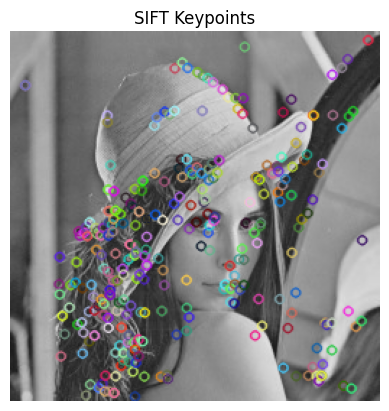

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('lena.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

sift_img = cv2.drawKeypoints(img, keypoints, None)
plt.imshow(cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis("off")
plt.show()


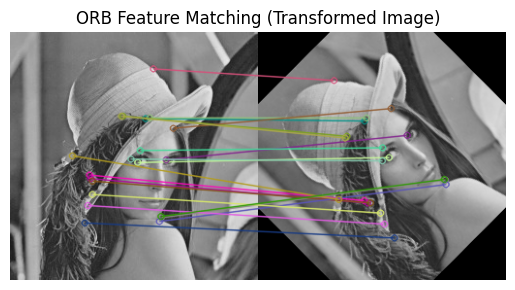

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('lena.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(gray, None)


rows, cols = gray.shape
M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 45, 1.0)
img2 = cv2.warpAffine(img, M, (cols, rows))
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp2, des2 = orb.detectAndCompute(gray2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)

matched_img = cv2.drawMatches(img, kp1, img2, kp2, matches[:20], None, flags=2)

plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("ORB Feature Matching (Transformed Image)")
plt.axis("off")
plt.show()


Saving single.jpg to single (3).jpg


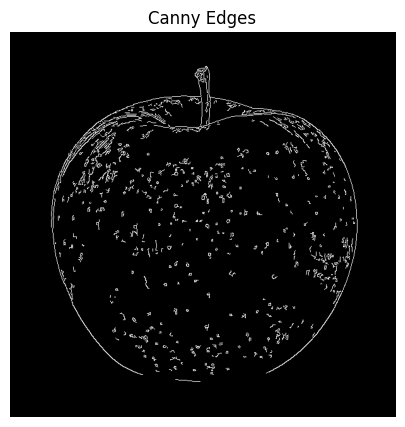

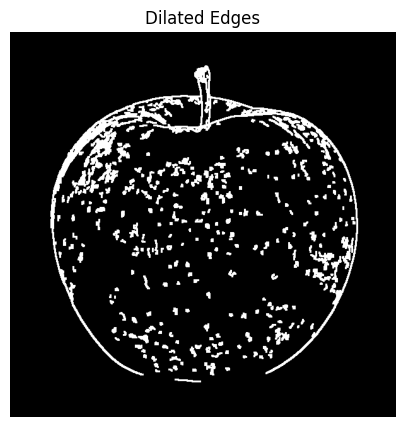

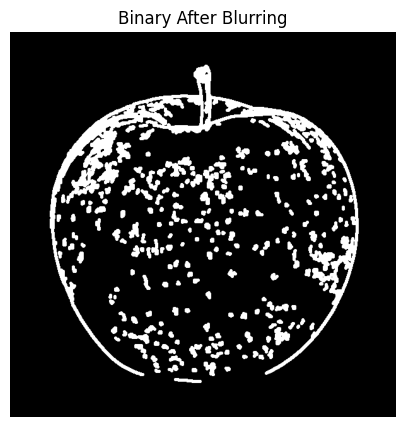

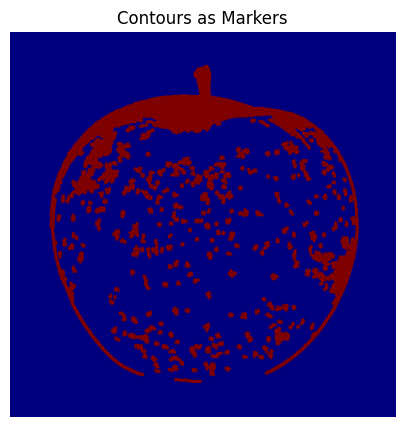

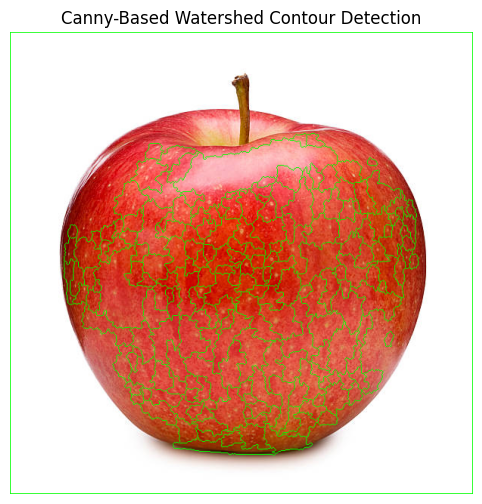

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# FOR GOOGLE COLAB: Upload the image
from google.colab import files
uploaded = files.upload()  # Upload your 'inpainting.jpg' file here

# Get the uploaded filename
filename = list(uploaded.keys())[0]

# Load the image
img = cv2.imread('single.jpg')
if img is None:
    raise FileNotFoundError(f"❌ Image not found or failed to load: {filename}")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Canny Edge Detection
edges = cv2.Canny(gray, 100, 200)

plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')
plt.show()

# Step 2: Dilation to strengthen edges
kernel = np.ones((3, 3), np.uint8)
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

plt.figure(figsize=(10, 5))
plt.imshow(edges_dilated, cmap='gray')
plt.title("Dilated Edges")
plt.axis('off')
plt.show()

# Step 3: Gaussian Blur + Thresholding for smooth binary image
blurred = cv2.GaussianBlur(edges_dilated, (5, 5), 0)
_, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 5))
plt.imshow(binary, cmap='gray')
plt.title("Binary After Blurring")
plt.axis('off')
plt.show()

# Step 4: Find Contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a marker image to draw the filled contours
markers = np.zeros_like(gray)
cv2.drawContours(markers, contours, -1, 255, thickness=cv2.FILLED)

plt.figure(figsize=(10, 5))
plt.imshow(markers, cmap='jet')
plt.title("Contours as Markers")
plt.axis('off')
plt.show()

# Step 5: Watershed segmentation
_, markers_labels = cv2.connectedComponents(markers.astype(np.uint8))
img_ws = img.copy()
markers_ws = cv2.watershed(img_ws, markers_labels)

# Highlight watershed boundaries in green
img_ws[markers_ws == -1] = [0, 255, 0]

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_ws, cv2.COLOR_BGR2RGB))
plt.title("Canny-Based Watershed Contour Detection")
plt.axis('off')
plt.show()


In [ ]:
import deeplake

train_ds = deeplake.load("hub://activeloop/cifar100-train")
test_ds = deeplake.load("hub://activeloop/cifar100-test")


/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-train



|

hub://activeloop/cifar100-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-test



\

hub://activeloop/cifar100-test loaded successfully.



In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).permute(2, 0, 1).float() / 255.0),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])


class DeepLakeCIFAR100(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img = self.ds[idx]['images'].numpy()
        label = int(self.ds[idx]['labels'].numpy())

        if self.transform:
            img = self.transform(img)

        return img, label


train_loader = DataLoader(DeepLakeCIFAR100(train_ds, transform), batch_size=64, shuffle=True)
test_loader = DataLoader(DeepLakeCIFAR100(test_ds, transform), batch_size=64, shuffle=False)


In [ ]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = models.resnet18(pretrained=False)
resnet34 = models.resnet34(pretrained=False)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

resnet18, resnet34 = resnet18.to(device), resnet34.to(device)


In [ ]:
import torch.optim as optim
import time

def train_model(model, loader, epochs=5):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")

# Train both models
print("Training ResNet-18...")
train_model(resnet18, train_loader)

print("\nTraining ResNet-34...")
train_model(resnet34, train_loader)


Training ResNet-18...


<ipython-input-5-900fd176e907>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds[idx]['labels'].numpy())


Epoch [1/5], Loss: 3.5097
Epoch [2/5], Loss: 2.7785
Epoch [3/5], Loss: 2.3549
Epoch [4/5], Loss: 2.0608
Epoch [5/5], Loss: 1.7934

Training ResNet-34...
Epoch [1/5], Loss: 3.7312
Epoch [2/5], Loss: 3.0083
Epoch [3/5], Loss: 2.6026
Epoch [4/5], Loss: 2.2976
Epoch [5/5], Loss: 2.0545


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    end = time.time()
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}, Inference time: {end-start:.2f} seconds")
    return acc, end - start

print("\nEvaluating ResNet-18...")
evaluate_model(resnet18, test_loader)

print("\nEvaluating ResNet-34...")
evaluate_model(resnet34, test_loader)



Evaluating ResNet-18...


<ipython-input-5-900fd176e907>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds[idx]['labels'].numpy())


Accuracy: 0.4351, Inference time: 659.27 seconds

Evaluating ResNet-34...


<ipython-input-5-900fd176e907>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.ds[idx]['labels'].numpy())


Accuracy: 0.3996, Inference time: 10.28 seconds


(0.3996, 10.282438278198242)